In [2]:
import matplotlib.pyplot as plt
from lib.article import article, outlet, dayPeriod, relatedWords
from lib.reddit import getPosts
from nltk.corpus import stopwords
from nltk import word_tokenize
from datetime import timedelta, datetime
import time
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv  # Imports

ModuleNotFoundError: No module named 'lib.article'

In [2]:
def getData(file):  # Function that reads data from a csv and returns as a list of  lists (columns and rows)
    csvFile = open(file, "r", encoding="utf-8")
    csvReader = csv.reader(csvFile, delimiter=",")
    data = []
    for row in csvReader:
        data.append(row)
    return data

In [3]:
backupDate = "12.07.21"
searchWord = ""
analyser = SentimentIntensityAnalyzer()
thisStopwords = set(stopwords.words("english"))
commonWordsCount = 2
minSimScore = 3
minWordFreq = 2
monthsIndex = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12,
}

outletListRaw = ["ABC News"]  # List containing just the names (string) of each  outlet


In [4]:
outletList = []
for mediaOutleta in outletListRaw:
    thisOulet = outlet(mediaOutleta)  # Convert this media outlet into an outlet object
    data = getData(
        "Backups/" + backupDate + "/" + mediaOutleta + ".csv"
    )  # Get article data from relavent csv file
    for headline in data:
        try:
            publishDate = headline[3]  # Get the date it was published, Howvever is in werid format
            publishDate = publishDate[publishDate.find(",") + 2 : publishDate.find(":") - 3]  # Remove unecessary parts
            publishDate = (publishDate[:2]+ "/" + str(monthsIndex[publishDate[3:6]]) + "/" + publishDate[9:])  # Add slashes and convert monthu names to number
            publishDate = datetime.strptime(publishDate, "%d/%m/%y")  # Convert to datetime object
            thisOulet.addArticle(article(headline[0], headline[1], headline[2], publishDate, outlet))  # Add this to the media objects articleList
        except KeyError:
            print("KEYERROR " + str(publishDate) + "\n" + str(headline[3]))
    outletList.append(thisOulet)
media = outletList[0]

In [5]:
startDate = datetime.today()  # The latest date possible to compare against
endDate = datetime.strptime("01/01/21", "%d/%m/%y")  # This date has to be sooner then any present in the database
for article in media.getArticles():
    if article.publishDate < startDate:
        startDate = (article.publishDate)  # Find the earliest date an article was published
    if article.publishDate > endDate:
        endDate = (article.publishDate)  # Find the latest date an article was published

possibleDates = []
articleCount = 0
daysCount = endDate - startDate
for i in range(daysCount.days):
    day = startDate + timedelta(days=i)
    possibleDates.append(day)  # Get list with every date between the 1st and last day an article was published by this outlet


In [6]:
for thisdate in possibleDates:
    availableHeadlines = ""  # Constants that are used by the specific 'day Period'
    totalSentiment = 0
    articleCount = 0
    for article in media.getArticles():
        if (article.publishDate == thisdate):  # If the article matches uup with the date being searched for
            if searchWord.lower() in article.headline:
                availableHeadlines += (article.headline.lower())  # Add to string (To be tokenized and then further analyzed)
                score = analyser.polarity_scores(article.headline)  # Get intensity score
                totalSentiment += score["compound"]  # Add that top the average
                articleCount += 1  # Increase the article count for this day

    availableHeadlines = word_tokenize(availableHeadlines)  # Tokenize thue headlines
    cleanHeadlines = []

    for word in availableHeadlines:
        if word not in thisStopwords:  # If the word is important
            if (len(word) > 2):  # And more then 2 letters (removes punctuation and other smaller words)
                cleanHeadlines.append(word)
    cleanHeadlines = list(Counter(cleanHeadlines).most_common(commonWordsCount))  # Get the most comon words for this day period

    if articleCount == 0:
        avgSentiment = 0
        cleanHeadlines = [["", 0]]

    else:
        avgSentiment = float(totalSentiment / articleCount)

    media.addDays(dayPeriod(thisdate, articleCount, cleanHeadlines, avgSentiment))  # add this day to the mesia's 'dayList'

In [7]:
wordsList = []
rotations = 0
thisStopwords = set(stopwords.words("english"))
for index, today in enumerate(media.getDays()):
    for i in range(commonWordsCount):
        thisWord = today.commonWord[i][0]
        if thisWord not in wordsList:
            print(thisWord)
            relatedList = []
            wordsList.append(thisWord)
            commons = getPosts(thisWord, 50, thisStopwords)
            keys = list(commons.keys())
            values = list(commons.values())
            for valueIndex, value in enumerate(values):
                if value >= minWordFreq:
                    relatedList.append([keys[valueIndex], value])
            today.setRelatedWords(relatedWords(thisWord, relatedList))
        else:
            print(thisWord + ' clone')
            sameIndex = wordsList.index(thisWord)
            foundObj = False
            k = 0
            while(foundObj == False):
                for j in range(commonWordsCount):
                    if media.getDays()[k].relatedWords[j].wordName == thisWord:
                        today.setRelatedWords(relatedWords(thisWord, media.getDays()[k].relatedWords[j].data))
                        foundObj = True
                k += 1
        rotations += 1
        print(rotations / (int(daysCount.days) * commonWordsCount))
            
            
            

police


Version 7.2.0 of praw is outdated. Version 7.4.0 was released Friday July 30, 2021.


0.05555555555555555
years
0.1111111111111111
covid
0.16666666666666666
new
0.2222222222222222
new clone
0.2777777777777778
covid-19
0.3333333333333333
covid-19 clone
0.3888888888888889
covid clone
0.4444444444444444
covid-19 clone
0.5
police clone
0.5555555555555556
australia
0.6111111111111112
covid-19 clone
0.6666666666666666
covid clone
0.7222222222222222
woman
0.7777777777777778
covid clone
0.8333333333333334
man
0.8888888888888888
australian
0.9444444444444444
covid-19 clone
1.0


In [8]:
minSimScore = 3
for index, today in enumerate(media.getDays()):
    if index + 1 != len(media.getDays()): # If not the last day 
        tomorrow = media.getDays()[index + 1]
        for todayCount in range(commonWordsCount): # For every freq Word for that day
            todayList = []
            print("TODAY = " + today.relatedWords[todayCount].wordName)
            hiScore = minSimScore # Innit defauults
            closestLink = relatedWords("NULL", [])
            # Generate processed list containing just the similar words for today
            for i in today.relatedWords[todayCount].data: 
                todayList.append(i[0])
            # For each commonWord today, look at all the common words tomorrow to find the closest match
            for tomorrowCount in range(commonWordsCount):
                thisScore = 0
                for wordPair in tomorrow.relatedWords[tomorrowCount].data:
                    if wordPair[0] in todayList:
                        thisScore += wordPair[1] + today.relatedWords[todayCount].data[todayList.index(wordPair[0])][1]
                        thisScore = round(thisScore / 2, 5)
                        # This score = Average of the two frequencies (today and yesterdays)
                if thisScore > hiScore: # Ensure each word is linked enough
                    closestLink = tomorrow.relatedWords[tomorrowCount]
                    hiScore = thisScore
            
            if hiScore == minSimScore:
                hiScore = 0
            print("MATCH FOR '" + today.relatedWords[todayCount].wordName + "' = '" + closestLink.wordName + "' Score = " + str(hiScore))
            today.relatedWords[todayCount].setLink(closestLink, hiScore)

TODAY = police
MATCH FOR 'police' = 'covid' Score = 7.75
TODAY = years
MATCH FOR 'years' = 'covid' Score = 4.32812
TODAY = covid
MATCH FOR 'covid' = 'new' Score = 10.01562
TODAY = new
MATCH FOR 'new' = 'covid-19' Score = 14.29688
TODAY = new
MATCH FOR 'new' = 'covid-19' Score = 14.29688
TODAY = covid-19
MATCH FOR 'covid-19' = 'covid' Score = 4.48429
TODAY = covid-19
MATCH FOR 'covid-19' = 'covid-19' Score = 4.00784
TODAY = covid
MATCH FOR 'covid' = 'police' Score = 12.0
TODAY = covid-19
MATCH FOR 'covid-19' = 'australia' Score = 5.125
TODAY = police
MATCH FOR 'police' = 'australia' Score = 6.46875
TODAY = australia
MATCH FOR 'australia' = 'covid' Score = 8.875
TODAY = covid-19
MATCH FOR 'covid-19' = 'covid' Score = 4.48429
TODAY = covid
MATCH FOR 'covid' = 'covid' Score = 4.00196
TODAY = woman
MATCH FOR 'woman' = 'man' Score = 18.10938
TODAY = covid
MATCH FOR 'covid' = 'australian' Score = 12.625
TODAY = man
MATCH FOR 'man' = 'australian' Score = 3.5


In [9]:
for today in media.getDays():
    for i in range(commonWordsCount):
        try:
            print(today.relatedWords[i].wordName + " - " + today.relatedWords[i].nextLink.wordName)
            print(today.relatedWords[i].linkScore)
        except AttributeError:
            print("ERROR")
            today.relatedWords[i].setLink(relatedWords("NULL", []), 0)
            print(today.relatedWords[i].wordName + " - " + today.relatedWords[i].nextLink.wordName)
    print("XX")
    

police - covid
7.75
years - covid
4.32812
XX
covid - new
10.01562
new - covid-19
14.29688
XX
new - covid-19
14.29688
covid-19 - covid
4.48429
XX
covid-19 - covid-19
4.00784
covid - police
12.0
XX
covid-19 - australia
5.125
police - australia
6.46875
XX
australia - covid
8.875
covid-19 - covid
4.48429
XX
covid - covid
4.00196
woman - man
18.10938
XX
covid - australian
12.625
man - australian
3.5
XX
ERROR
australian - NULL
ERROR
covid-19 - NULL
XX


In [10]:
from ipywidgets import *

<IPython.core.display.Javascript object>


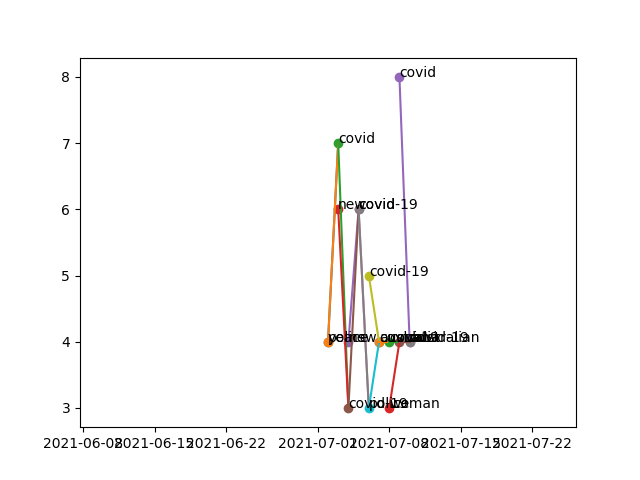

years - covid
covid
years - covid
covid
new - covid-19
covid-19
new - covid-19
covid-19
covid-19 - covid
covid
covid-19 - covid
covid
covid - police
police
covid - police
police
police - australia
australia
police - australia
australia
covid-19 - covid
covid
covid-19 - covid
covid
woman - man
man
woman - man
man
man - australian
australian
man - australian
australian


In [11]:
%matplotlib notebook
for dayIndex, day in enumerate(media.getDays()):
    for i in range(commonWordsCount):
        plt.scatter(day.date, day.commonWord[i][1])
        plt.annotate(day.commonWord[i][0], (day.date, day.commonWord[i][1]))
        
    if dayIndex + 1 != len(media.getDays()):
        tomorrow = media.getDays()[dayIndex + 1]
        for dayCount in range(commonWordsCount):
            print(day.relatedWords[i].wordName + " - " + day.relatedWords[i].nextLink.wordName)
            link = day.relatedWords[i].nextLink
            for tomorrowCount in range(commonWordsCount):
                if tomorrow.relatedWords[tomorrowCount] == link:
                    x = [day.date, tomorrow.date]
                    y = [day.commonWord[dayCount][1], tomorrow.commonWord[tomorrowCount][1]]
                    plt.plot(x, y)
                    print(tomorrow.relatedWords[tomorrowCount].wordName)
plt.show()

            


In [13]:
# Write to a file

fileStr = ""
fName = ""
media = outletList[0]
#for media in outletList
fName = r"Backups/" + backupDate + "/processed/" + media.name + '.txt'
fileStr +=  "<searchWord>" + searchWord + "\n"
fileStr += "<commonWordCount>" + str(commonWordsCount) + "\n\n"
for todayIndex, today in enumerate(media.getDays()):
    fileStr += "<date>" + str(today.date) + "\n"
    fileStr += "<freq>" + str(today.freq) + "\n"
    fileStr += "<avgSentiment>" + str(round(today.avgSentiment, 3)) + "\n"
    for i in range(commonWordsCount):
        fileStr += "<commonWord>" + str(i) + str(today.relatedWords[i].wordName) + "\n"
        fileStr += "<commonWordFreq>" + str(i) + str(today.commonWord[i][1]) + "\n"
        fileStr +=  "<linkWordName>" + str(today.relatedWords[i].nextLink.wordName) + "\n"
        fileStr += "<linkScore>" + str(today.relatedWords[i].linkScore) + "\n"
        
    fileStr += "\n"

print(fileStr)
f = open(fName, "w", encoding='utf-8')
f.writelines(fileStr)
f.close()

<searchWord>
<commonWordCount>2

<date>2021-07-02 00:00:00
<freq>35
<avgSentiment>-0.119
<commonWord>0police
<commonWordFreq>04
<linkWordName>covid
<linkScore>7.75
<commonWord>1years
<commonWordFreq>14
<linkWordName>covid
<linkScore>4.32812

<date>2021-07-03 00:00:00
<freq>50
<avgSentiment>-0.06
<commonWord>0covid
<commonWordFreq>07
<linkWordName>new
<linkScore>10.01562
<commonWord>1new
<commonWordFreq>16
<linkWordName>covid-19
<linkScore>14.29688

<date>2021-07-04 00:00:00
<freq>42
<avgSentiment>-0.101
<commonWord>0new
<commonWordFreq>04
<linkWordName>covid-19
<linkScore>14.29688
<commonWord>1covid-19
<commonWordFreq>13
<linkWordName>covid
<linkScore>4.48429

<date>2021-07-05 00:00:00
<freq>45
<avgSentiment>-0.127
<commonWord>0covid-19
<commonWordFreq>06
<linkWordName>covid-19
<linkScore>4.00784
<commonWord>1covid
<commonWordFreq>16
<linkWordName>police
<linkScore>12.0

<date>2021-07-06 00:00:00
<freq>46
<avgSentiment>-0.179
<commonWord>0covid-19
<commonWordFreq>05
<linkWordName>austr

In [14]:
for today in media.getDays():
    print(today.commonWord)

[('police', 4), ('years', 4)]
[('covid', 7), ('new', 6)]
[('new', 4), ('covid-19', 3)]
[('covid-19', 6), ('covid', 6)]
[('covid-19', 5), ('police', 3)]
[('australia', 4), ('covid-19', 4)]
[('covid', 4), ('woman', 3)]
[('covid', 8), ('man', 4)]
[('australian', 4), ('covid-19', 4)]
